# kMeans, DBSCAN

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

In [2]:
from clickhouse_driver import Client


user_name = 'user'
pwd = 'password'

# creating connection ClickHouse
client = Client(host='clickhouse.lab.karpov.courses', port=9000,
                user=user_name, password=pwd, database='hardda')

# checking connection
result = client.execute("SELECT * FROM hardda.user_dm_events LIMIT 1")

# showing the result
for row in result[0:1]:
    print(row)

(datetime.date(2022, 2, 1), datetime.date(2022, 1, 31), 'android', 'f7411212fd0e2523e126cbfdd3f226c211212', '4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1', 22, 11, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0)


## Tasks

### Task 1.

 **Write an SQL query to load the data.**

`user_passports`

In [3]:
user_passports_desc = client.execute("""
DESCRIBE TABLE user_passports
""")

user_passports_desc

[('execution_date', 'Date', '', '', '', '', ''),
 ('passport_id', 'UInt32', '', '', '', '', ''),
 ('global_id', 'UInt32', '', '', '', '', ''),
 ('created_at', 'DateTime', '', '', '', '', ''),
 ('user_type_id', 'UInt32', '', '', '', '', ''),
 ('user_type_name', 'String', '', '', '', '', ''),
 ('user_type_changed_at', 'DateTime', '', '', '', '', ''),
 ('user_type_cars_id', 'UInt32', '', '', '', '', ''),
 ('user_type_cars_name', 'String', '', '', '', '', ''),
 ('user_type_cars_changed_at', 'DateTime', '', '', '', '', '')]

In [4]:
query = '''
SELECT 
  up.*
FROM 
  user_passports up
'''

In [5]:
result = client.execute(query)

In [6]:
len(result)

2780181

In [7]:
user_passports_df = pd.DataFrame(result, 
                  columns=['execution_date', 'passport_id',
                           'global_id', 'created_at',
                           'user_type_id', 'user_type_name',
                           'user_type_changed_at', 'user_type_cars_id',
                           'user_type_cars_name', 'user_type_cars_changed_at'
                           ])

user_passports_df.head()

,execution_date,passport_id,global_id,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at
0,2023-01-31,142628770,147573771,2021-11-29 20:19:13,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16
1,2023-01-31,134554897,138434457,2019-03-25 22:38:32,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16
2,2023-01-31,134604257,138479404,2019-03-29 12:07:31,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16
3,2023-01-31,134611349,138489998,2019-03-30 09:16:51,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16
4,2023-01-31,134698167,138621384,2019-04-09 16:14:42,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16


In [8]:
user_passports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780181 entries, 0 to 2780180
Data columns (total 10 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   execution_date             object        
 1   passport_id                int64         
 2   global_id                  int64         
 3   created_at                 datetime64[ns]
 4   user_type_id               int64         
 5   user_type_name             object        
 6   user_type_changed_at       datetime64[ns]
 7   user_type_cars_id          int64         
 8   user_type_cars_name        object        
 9   user_type_cars_changed_at  datetime64[ns]
dtypes: datetime64[ns](3), int64(4), object(3)
memory usage: 212.1+ MB


In [9]:
user_passports_df['execution_date'] = pd.to_datetime(user_passports_df['execution_date'], format='%Y-%m-%d')

In [10]:
user_passports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780181 entries, 0 to 2780180
Data columns (total 10 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   execution_date             datetime64[ns]
 1   passport_id                int64         
 2   global_id                  int64         
 3   created_at                 datetime64[ns]
 4   user_type_id               int64         
 5   user_type_name             object        
 6   user_type_changed_at       datetime64[ns]
 7   user_type_cars_id          int64         
 8   user_type_cars_name        object        
 9   user_type_cars_changed_at  datetime64[ns]
dtypes: datetime64[ns](4), int64(4), object(2)
memory usage: 212.1+ MB


`live_adverts`

In [11]:
live_adverts_desc = client.execute("""
DESCRIBE TABLE live_adverts
""")

live_adverts_desc

[('execution_date', 'Date32', '', '', '', 'DoubleDelta', ''),
 ('advert_id', 'UInt64', '', '', '', 'T64', ''),
 ('created_at', 'DateTime', '', '', '', 'DoubleDelta', ''),
 ('price', 'UInt64', '', '', '', 'Gorilla', ''),
 ('region', 'LowCardinality(String)', '', '', '', '', ''),
 ('user_id', 'UInt32', '', '', '', 'T64', ''),
 ('platform', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_brand', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_model', 'LowCardinality(String)', '', '', '', '', ''),
 ('passport_id', 'UInt32', '', '', '', 'T64', ''),
 ('year', 'LowCardinality(String)', '', '', '', '', ''),
 ('userType', 'UInt8', '', '', '', 'T64', '')]

In [12]:
query = '''
SELECT 
  la.passport_id,
  COUNT(DISTINCT(la.advert_id)) AS n_ads,
  MIN(la.created_at) AS first_ad,
  AVG(la.price) AS mean_price,
  AVG(CAST(la.year, 'Int64')) AS mean_year
FROM 
  live_adverts la
WHERE 
  la.region = 'Омск'
    AND la.price > 1000
      AND la.year != '0'
GROUP BY
  la.passport_id
'''

In [13]:
result = client.execute(query)

In [14]:
len(result)

35843

In [15]:
live_adverts_df = pd.DataFrame(result, 
                  columns=['passport_id', 'n_ads', 
                           'first_ad', 'mean_price',
                           'mean_year'
                           ])

live_adverts_df.head()

,passport_id,n_ads,first_ad,mean_price,mean_year
0,141450171,2,2022-05-09 14:12:54,1.761905e+05,2006.000000
1,123719602,1,2021-09-15 14:11:38,1.100000e+06,2008.000000
2,144667270,2,2022-12-06 14:41:13,5.000000e+05,2013.000000
3,134267823,16,2022-06-18 15:31:31,6.517922e+05,2004.701299
4,136204801,2,2022-06-14 02:52:06,2.768182e+05,2005.818182


In [16]:
live_adverts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35843 entries, 0 to 35842
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   passport_id  35843 non-null  int64         
 1   n_ads        35843 non-null  int64         
 2   first_ad     35843 non-null  datetime64[ns]
 3   mean_price   35843 non-null  float64       
 4   mean_year    35843 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 1.4 MB


`user_transactions`

In [17]:
user_transactions_desc = client.execute("""
DESCRIBE TABLE user_transactions
""")

user_transactions_desc

[('payment_date', 'Date', '', '', '', '', ''),
 ('id', 'Int32', '', '', '', '', ''),
 ('type', 'String', '', '', '', '', ''),
 ('sign', 'Int32', '', '', '', '', ''),
 ('amount', 'Int32', '', '', '', '', ''),
 ('tstamp', 'DateTime', '', '', '', '', ''),
 ('advert_id', 'Int32', '', '', '', '', ''),
 ('passport_id', 'Int32', '', '', '', '', ''),
 ('balance_consumption', 'Int32', '', '', '', '', '')]

In [18]:
query = '''
SELECT 
  ut.passport_id,
  COUNT(DISTINCT(ut.type)) AS n_types,
  SUM(ut.sign) AS top_type,
  AVG(ut.balance_consumption) AS mean_transaction
FROM 
  user_transactions ut
GROUP BY
  ut.passport_id
'''

In [19]:
result = client.execute(query)

In [20]:
len(result)

1714980

In [21]:
user_transactions_df = pd.DataFrame(result, 
                  columns=['passport_id', 'n_types', 
                           'top_type', 'mean_transaction'
                           ])

user_transactions_df.head()

,passport_id,n_types,top_type,mean_transaction
0,133483447,2,28,6.833333
1,144659952,1,1,0.000000
2,136275535,1,6,0.000000
3,123683386,4,23,17.600000
4,136981601,2,9,17.272727


Merging data. 

In [22]:
df = pd.merge(user_passports_df, live_adverts_df, on='passport_id', how='inner')

In [23]:
df = pd.merge(df, user_transactions_df, on='passport_id', how='inner')

In [24]:
df

,execution_date,passport_id,global_id,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at,n_ads,first_ad,mean_price,mean_year,n_types,top_type,mean_transaction
0,2023-01-31,134698167,138621384,2019-04-09 16:14:42,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-09-20 11:54:19,8.521212e+05,2020.000000,4,-10,297.500000
1,2023-01-31,123776196,123755241,2012-02-28 14:48:12,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,3,2022-02-04 14:31:29,1.088286e+06,2019.000000,5,-9,145.217391
2,2023-01-31,123801906,123780948,2012-04-12 09:00:26,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,8,2022-02-09 12:30:44,2.083562e+06,2011.452055,3,11,40.882353
3,2023-01-31,136625705,141382448,2019-12-12 14:25:16,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,5,2022-02-01 03:18:49,4.602500e+05,2005.500000,5,5,87.000000
4,2023-01-31,141924129,146727434,2021-08-07 17:13:05,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,5,2022-08-14 06:49:01,9.153333e+04,2001.000000,1,4,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30698,2023-01-31,140140656,144655147,2020-11-30 00:13:39,777,profi,2022-11-07 14:14:03,6,cars_seller,2022-11-07 14:14:03,2,2022-11-05 11:07:04,8.611765e+05,2004.764706,12,125,288.696833
30699,2023-01-31,140805655,145457194,2021-03-03 22:37:12,777,profi,2022-07-29 01:31:07,6,cars_seller,2022-07-29 01:31:07,2,2021-12-12 18:44:15,2.203360e+06,2017.000000,9,106,188.234694
30700,2023-01-31,141933123,146738442,2021-08-09 01:22:10,777,profi,2023-01-31 12:44:40,6,cars_seller,2023-01-31 12:44:40,13,2022-07-17 12:34:09,2.402632e+05,2001.736842,1,14,0.000000
30701,2023-01-31,134858035,138873132,2019-04-29 18:51:44,777,profi,2022-11-20 12:46:23,6,cars_seller,2022-11-20 12:46:23,9,2021-07-07 17:42:33,6.618100e+05,2005.840000,10,57,205.609959


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30703 entries, 0 to 30702
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   execution_date             30703 non-null  datetime64[ns]
 1   passport_id                30703 non-null  int64         
 2   global_id                  30703 non-null  int64         
 3   created_at                 30703 non-null  datetime64[ns]
 4   user_type_id               30703 non-null  int64         
 5   user_type_name             30703 non-null  object        
 6   user_type_changed_at       30703 non-null  datetime64[ns]
 7   user_type_cars_id          30703 non-null  int64         
 8   user_type_cars_name        30703 non-null  object        
 9   user_type_cars_changed_at  30703 non-null  datetime64[ns]
 10  n_ads                      30703 non-null  int64         
 11  first_ad                   30703 non-null  datetime64[ns]
 12  mean

In [26]:
del user_passports_df
del live_adverts_df
del user_transactions_df

### Task 2. 

**Find median value of days since ad creation?**

In [27]:
df.head()

,execution_date,passport_id,global_id,created_at,user_type_id,user_type_name,user_type_changed_at,user_type_cars_id,user_type_cars_name,user_type_cars_changed_at,n_ads,first_ad,mean_price,mean_year,n_types,top_type,mean_transaction
0,2023-01-31,134698167,138621384,2019-04-09 16:14:42,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,1,2022-09-20 11:54:19,8.521212e+05,2020.000000,4,-10,297.500000
1,2023-01-31,123776196,123755241,2012-02-28 14:48:12,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,3,2022-02-04 14:31:29,1.088286e+06,2019.000000,5,-9,145.217391
2,2023-01-31,123801906,123780948,2012-04-12 09:00:26,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,8,2022-02-09 12:30:44,2.083562e+06,2011.452055,3,11,40.882353
3,2023-01-31,136625705,141382448,2019-12-12 14:25:16,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,5,2022-02-01 03:18:49,4.602500e+05,2005.500000,5,5,87.000000
4,2023-01-31,141924129,146727434,2021-08-07 17:13:05,0,simple_user,2106-02-07 06:28:16,0,cars_simple,2106-02-07 06:28:16,5,2022-08-14 06:49:01,9.153333e+04,2001.000000,1,4,0.000000


In [28]:
df['days_ago'] = (df.execution_date.dt.date - df.first_ad.dt.date).dt.days

In [29]:
np.median(df.days_ago)

269.0

### Task 3.  

**What is the max cars age?** 

In [30]:
df['mean_n_years'] = df.execution_date.dt.year - df.mean_year

In [31]:
df.mean_n_years.max()

73.0

### Task 4. 

**Create a `buyer` feature. Do we have more buyers or sellers in our dataset?**  

In [32]:
df['buyer'] = df.top_type.apply(lambda x: 1 if x < 0 else 0)

In [33]:
df.buyer.value_counts()

0    22844
1     7859
Name: buyer, dtype: int64

### Task 5. 

**Log-transform `price`, choose 6 features, delete outliers and StandardScale them.**

In [34]:
df.sort_values('passport_id', inplace=True)

In [35]:
df = df.reset_index(drop=True)

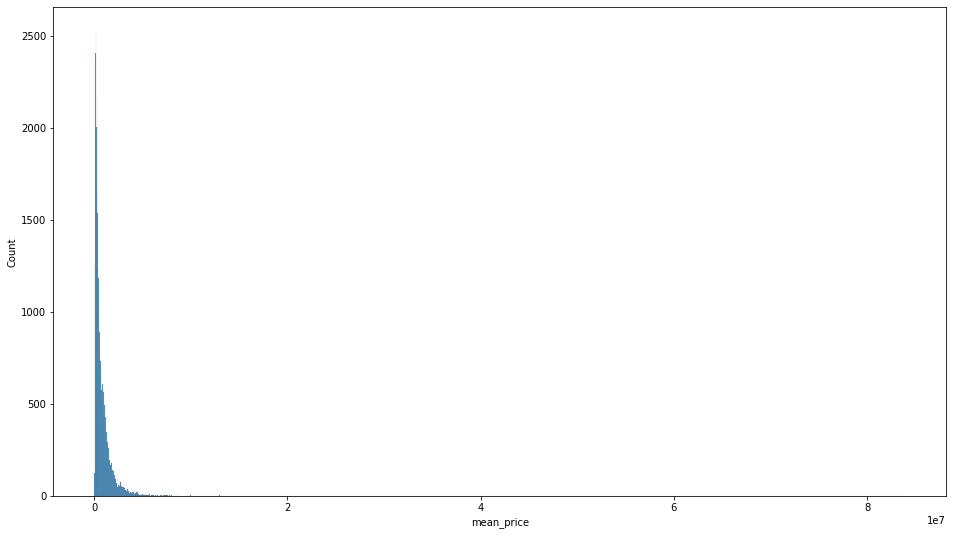

In [36]:
plt.figure(figsize=(16, 9))
sns.histplot(df.mean_price);

In [37]:
df['log_price']= np.log(df['mean_price']) 

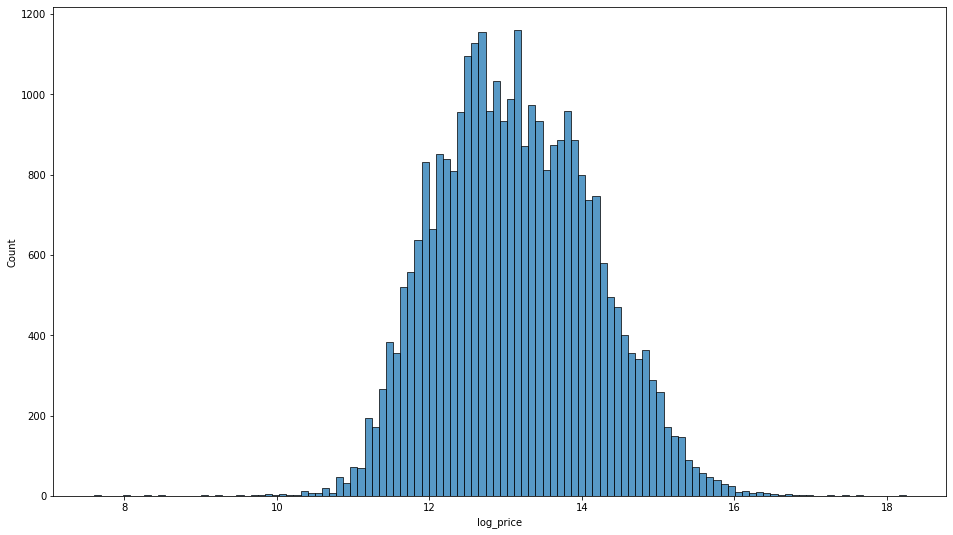

In [38]:
plt.figure(figsize=(16, 9))
sns.histplot(df.log_price);

In [39]:
df.head(3).T

,0,1,2
execution_date,2023-01-31 00:00:00,2023-01-31 00:00:00,2023-01-31 00:00:00
passport_id,123463130,123463864,123464158
global_id,123456861,123457429,123457652
created_at,2009-04-03 19:46:43,2009-04-05 17:11:29,2009-04-06 12:29:57
user_type_id,777,0,0
user_type_name,profi,simple_user,simple_user
user_type_changed_at,2023-01-31 12:44:40,2106-02-07 06:28:16,2106-02-07 06:28:16
user_type_cars_id,0,0,0
user_type_cars_name,cars_simple,cars_simple,cars_simple
user_type_cars_changed_at,2106-02-07 06:28:16,2106-02-07 06:28:16,2106-02-07 06:28:16


In [40]:
data = df[['passport_id', 'n_ads', 'n_types', 'days_ago', 'log_price', 'mean_n_years', 'buyer']]

In [41]:
data.shape

(30703, 7)

In [42]:
data = data[data['n_ads'] < np.quantile(df.n_ads, .99)]

In [43]:
data.shape

(30391, 7)

In [44]:
data = data[data['mean_n_years'] < np.quantile(df.mean_n_years, .99)]

In [45]:
data.shape

(30053, 7)

In [46]:
data = data[data['days_ago'] < np.quantile(df.days_ago, .99)]

In [47]:
data.shape

(29763, 7)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29763 entries, 0 to 30702
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passport_id   29763 non-null  int64  
 1   n_ads         29763 non-null  int64  
 2   n_types       29763 non-null  int64  
 3   days_ago      29763 non-null  int64  
 4   log_price     29763 non-null  float64
 5   mean_n_years  29763 non-null  float64
 6   buyer         29763 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 1.8 MB


In [49]:
data = data.astype({'passport_id': 'str'})

In [50]:
col_transformer_with_selector = ColumnTransformer(
    transformers=[             
        ('StandardScaler', StandardScaler(), selector(dtype_include='number'))
    ],
    remainder='passthrough',          
    verbose_feature_names_out=False   
).set_output(transform='pandas')  

In [51]:
data_scaled = Pipeline(
    [
        ('col_transformer', col_transformer_with_selector)
    ]
)

In [52]:
data_scaled.fit_transform(data)

,n_ads,n_types,days_ago,log_price,mean_n_years,buyer,passport_id
0,6.558351,2.719888,1.000688,1.962220,-1.094520,-0.581036,123463130
1,-0.204847,1.618180,2.455233,1.486273,-0.630965,-0.581036,123463864
2,-0.543007,-0.218000,-1.204340,0.594066,-0.718880,1.721064,123464158
3,-0.543007,-0.952472,-0.662754,0.938961,-1.539416,-0.581036,123464314
4,-0.373927,-0.952472,0.381733,2.109985,-1.598025,-0.581036,123465872
...,...,...,...,...,...,...,...
30698,-0.543007,-0.952472,-1.970297,-0.523770,-0.718880,-0.581036,144977962
30699,-0.543007,-0.585236,-1.978034,-0.341897,1.859949,1.721064,144979974
30700,-0.543007,0.516472,-1.978034,0.772318,-0.250002,-0.581036,144983244
30701,-0.543007,-0.218000,-1.978034,-0.341897,-0.484441,-0.581036,144983322


### Task 6. 

**Find the best `eps` parameter for DBSCAN algorithm.**

In [53]:
data_scaled_df = pd.DataFrame(data_scaled.fit_transform(data),
                              columns=['n_ads', 'n_types', 'days_ago',
                                       'log_price', 'mean_n_years', 'buyer', 'passport_id'])

In [54]:
data_scaled_df

,n_ads,n_types,days_ago,log_price,mean_n_years,buyer,passport_id
0,6.558351,2.719888,1.000688,1.962220,-1.094520,-0.581036,123463130
1,-0.204847,1.618180,2.455233,1.486273,-0.630965,-0.581036,123463864
2,-0.543007,-0.218000,-1.204340,0.594066,-0.718880,1.721064,123464158
3,-0.543007,-0.952472,-0.662754,0.938961,-1.539416,-0.581036,123464314
4,-0.373927,-0.952472,0.381733,2.109985,-1.598025,-0.581036,123465872
...,...,...,...,...,...,...,...
30698,-0.543007,-0.952472,-1.970297,-0.523770,-0.718880,-0.581036,144977962
30699,-0.543007,-0.585236,-1.978034,-0.341897,1.859949,1.721064,144979974
30700,-0.543007,0.516472,-1.978034,0.772318,-0.250002,-0.581036,144983244
30701,-0.543007,-0.218000,-1.978034,-0.341897,-0.484441,-0.581036,144983322


In [55]:
data_scaled_df = data_scaled_df.drop('passport_id', axis=1)

In [56]:
eps_lst = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2, 2.5, 3, 4, 5]
ans_dct = dict()

for eps in eps_lst[:7]:
    dbscan = DBSCAN(eps=eps, n_jobs=1)
    dbscan.fit(data_scaled_df)
    result = dbscan.labels_
    
    if len(set(result)) >= 3:
        silhouette_ = silhouette_score(data_scaled_df, result)
        ans_dct[eps] = silhouette_

In [57]:
ans_dct

{0.1: -0.403258713760892,
 0.3: -0.5417368065803986,
 0.5: -0.2836837665880331,
 0.7: 0.16073287792476046,
 1: 0.2304060337826599,
 1.5: 0.23877790704382354,
 2: 0.2384598292332369}

### Task 7. 

**Find amount of clusters and number of items in them for the best `eps` parameter obtained on the previous step.**

In [58]:
max_v = -1
max_k = 0

for k, v in ans_dct.items():
    if v > max_v:
        max_v = v
        max_k = k

In [59]:
print(max_k)

1.5


In [60]:
dbscan = DBSCAN(eps=max_k, n_jobs=1)
dbscan.fit(data_scaled_df)
result = dbscan.labels_

unique, counts = np.unique(result, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   -1    31]
 [    0 22230]
 [    1  7502]]


### Task 8. 

**Find optimal number of clusters using kMeans algorithm.**

In [61]:
data_scaled_df

,n_ads,n_types,days_ago,log_price,mean_n_years,buyer
0,6.558351,2.719888,1.000688,1.962220,-1.094520,-0.581036
1,-0.204847,1.618180,2.455233,1.486273,-0.630965,-0.581036
2,-0.543007,-0.218000,-1.204340,0.594066,-0.718880,1.721064
3,-0.543007,-0.952472,-0.662754,0.938961,-1.539416,-0.581036
4,-0.373927,-0.952472,0.381733,2.109985,-1.598025,-0.581036
...,...,...,...,...,...,...
30698,-0.543007,-0.952472,-1.970297,-0.523770,-0.718880,-0.581036
30699,-0.543007,-0.585236,-1.978034,-0.341897,1.859949,1.721064
30700,-0.543007,0.516472,-1.978034,0.772318,-0.250002,-0.581036
30701,-0.543007,-0.218000,-1.978034,-0.341897,-0.484441,-0.581036


In [62]:
clusters_lst = list(range(3, 11))
ans_dct = dict()

for cluster in clusters_lst:
    kmeans = KMeans(n_clusters=cluster, random_state=42, n_init=1)
    kmeans.fit(data_scaled_df)
    
    silhouette_ = silhouette_score(data_scaled_df, kmeans.labels_)
    ans_dct[cluster] = silhouette_

In [63]:
ans_dct

{3: 0.2078370891959297,
 4: 0.25820646534206115,
 5: 0.24758902167248617,
 6: 0.25357512575681407,
 7: 0.2194918439316475,
 8: 0.20554205991860822,
 9: 0.20657240877578392,
 10: 0.2016509872357886}

### Task 9. 

**Use the best `silhoutte_score` parameter for your model. Find the number of users in the smallest cluster.**

In [64]:
max_v = -1
max_k = 0

for k, v in ans_dct.items():
    if v > max_v:
        max_v = v
        max_k = k
        
print(f'{max_k} clusters have the best silhoutte_score: {max_v}')

4 clusters have the best silhoutte_score: 0.25820646534206115


In [65]:
kmeans = KMeans(n_clusters=max_k, random_state=42, n_init=1)
kmeans.fit(data_scaled_df)

print(f'Silhoutte_score: {silhouette_score(data_scaled_df, kmeans.labels_)}')

unique, counts = np.unique(kmeans.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

Silhoutte_score: 0.25820646534206115
[[    0 11927]
 [    1  7252]
 [    2  2015]
 [    3  8569]]


In [66]:
data['cluster'] = kmeans.labels_
data.head()

,passport_id,n_ads,n_types,days_ago,log_price,mean_n_years,buyer,cluster
0,123463130,43,11,386,15.103656,7.795407,0,2
1,123463864,3,8,574,14.626536,11.750000,0,3
2,123464158,1,3,101,13.732129,11.000000,1,1
3,123464314,1,1,171,14.077875,4.000000,0,3
4,123465872,2,1,306,15.251785,3.500000,0,3


In [67]:
data.cluster.value_counts()

0    11927
3     8569
1     7252
2     2015
Name: cluster, dtype: int64

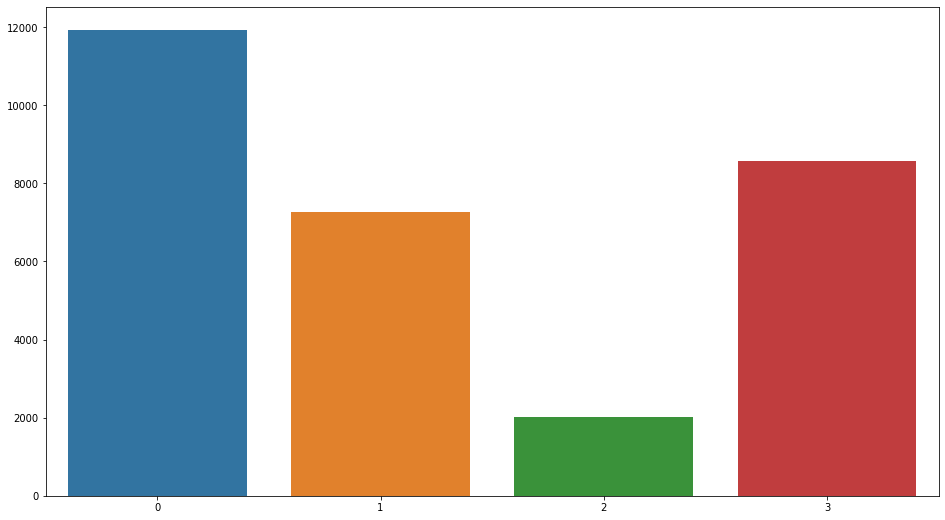

In [68]:
plt.figure(figsize=(16, 9))
sns.barplot(x=data.cluster.value_counts().index, y=data.cluster.value_counts().to_list());

### Task 10. 

**Calculate mean values for each clusters features.**

In [69]:
data = pd.merge(data, df[['passport_id', 'mean_price']].astype({'passport_id': 'str'}), how='inner', on='passport_id')

In [70]:
data

,passport_id,n_ads,n_types,days_ago,log_price,mean_n_years,buyer,cluster,mean_price
0,123463130,43,11,386,15.103656,7.795407,0,2,3.626054e+06
1,123463864,3,8,574,14.626536,11.750000,0,3,2.250214e+06
2,123464158,1,3,101,13.732129,11.000000,1,1,9.200000e+05
3,123464314,1,1,171,14.077875,4.000000,0,3,1.300000e+06
4,123465872,2,1,306,15.251785,3.500000,0,3,4.205000e+06
...,...,...,...,...,...,...,...,...,...
29758,144977962,1,1,2,12.611538,11.000000,0,0,3.000000e+05
29759,144979974,1,2,1,12.793859,33.000000,1,1,3.600000e+05
29760,144983244,1,5,1,13.910821,15.000000,0,3,1.100000e+06
29761,144983322,1,3,1,12.793859,13.000000,0,0,3.600000e+05


In [71]:
cluster_stats = data.groupby('cluster', as_index=False).agg({'n_ads': 'mean',
                                             'mean_price': 'mean',
                                             'n_types': 'mean',
                                             'days_ago': 'mean',
                                             'mean_n_years': 'mean',
                                             'buyer': 'mean',})

In [72]:
cluster_stats

,cluster,n_ads,mean_price,n_types,days_ago,mean_n_years,buyer
0,0,3.058355,3.034001e+05,2.282217,228.992370,22.576476,0.003521
1,1,2.538058,9.578379e+05,4.271925,287.532819,16.361027,1.000000
2,2,22.249628,7.480136e+05,4.583623,345.472953,17.406206,0.098759
3,3,2.991248,1.571562e+06,4.612090,248.161279,10.144616,0.002217


### Task 11. 

**Which cluster did users who registered significantly before the rest fall into?**

In [73]:
cluster_stats[cluster_stats.days_ago == cluster_stats.days_ago.max()].cluster.values[0]

2

### Task 12. 

**Which cluster only contains users who bought cars more often than they sold them?**

In [74]:
cluster_stats[cluster_stats.buyer == cluster_stats.buyer.max()].cluster.values[0]

1

### Task 13. 

**Which cluster contains sellers / buyers of the cheapest cars?**

In [75]:
cluster_stats[cluster_stats.mean_price == cluster_stats.mean_price.min()].cluster.values[0]

0

### Task 14. 

**Which cluster contains users who placed an average of more ads?**

In [76]:
cluster_stats[cluster_stats.n_ads == cluster_stats.n_ads.max()].cluster.values[0]

2

### Task 15. 

**Reduce the feature space dimension to 3 using PCA. Create a correlation matrix between components and features.**

In [77]:
data_cp = data[['n_ads', 'n_types', 'days_ago', 'log_price', 'mean_n_years', 'buyer']]

In [78]:
data_scaled_cp = pd.DataFrame(data_scaled.fit_transform(data_cp),
                              columns=['n_ads', 'n_types', 'days_ago',
                                       'log_price', 'mean_n_years', 'buyer'])

In [79]:
data_scaled_cp

,n_ads,n_types,days_ago,log_price,mean_n_years,buyer
0,6.558351,2.719888,1.000688,1.962220,-1.094520,-0.581036
1,-0.204847,1.618180,2.455233,1.486273,-0.630965,-0.581036
2,-0.543007,-0.218000,-1.204340,0.594066,-0.718880,1.721064
3,-0.543007,-0.952472,-0.662754,0.938961,-1.539416,-0.581036
4,-0.373927,-0.952472,0.381733,2.109985,-1.598025,-0.581036
...,...,...,...,...,...,...
29758,-0.543007,-0.952472,-1.970297,-0.523770,-0.718880,-0.581036
29759,-0.543007,-0.585236,-1.978034,-0.341897,1.859949,1.721064
29760,-0.543007,0.516472,-1.978034,0.772318,-0.250002,-0.581036
29761,-0.543007,-0.218000,-1.978034,-0.341897,-0.484441,-0.581036


In [80]:
pca = PCA(n_components=3, random_state=42)
pca.fit(data_scaled_cp)
data_pca = pd.DataFrame(pca.transform(data_scaled_cp), columns=[f"PCA_{i+1}" for i in range(3)])

In [81]:
data_pca

,PCA_1,PCA_2,PCA_3
0,3.700069,4.181833,3.966882
1,2.391656,1.259064,0.255868
2,0.752460,-1.387330,-1.209656
3,0.655049,-1.818352,0.898968
4,1.661555,-1.373332,1.080243
...,...,...,...
29758,-0.997677,-1.999364,0.598127
29759,-1.591474,-0.858474,-1.863920
29760,0.186328,-1.765295,0.467390
29761,-0.690984,-1.765551,0.461491


In [82]:
pca.explained_variance_ratio_

array([0.29865068, 0.22025376, 0.18006018])

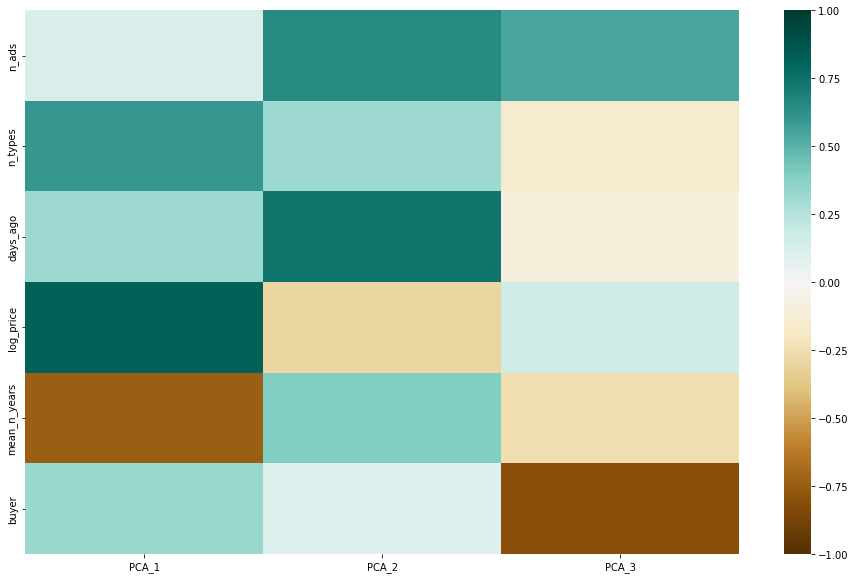

In [83]:
fst_component_corr = data_scaled_cp.corrwith(data_pca.PCA_1)
scnd_component_corr = data_scaled_cp.corrwith(data_pca.PCA_2)
thrd_component_corr = data_scaled_cp.corrwith(data_pca.PCA_3)

corrs = pd.concat(
    (
        fst_component_corr,
        scnd_component_corr,
        thrd_component_corr
    ),
    axis=1
)

corrs.columns = [f"PCA_{i+1}" for i in range(3)]

fig = plt.figure()
fig.set_size_inches(16, 10)

sns.heatmap(corrs, 
            xticklabels=corrs.columns,
            yticklabels=corrs.index,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

plt.show()

### Task 16. 

**Label the KMeans clustering results in the principal component coordinates. Is it visible on the graph how the clusters are divided?**

In [84]:
data_pca_cluster = pd.merge(data_pca.reset_index(), 
                            data.reset_index()[['index', 'cluster']],
                            how='inner', on='index').drop('index', axis=1)

In [85]:
data_pca_cluster

,PCA_1,PCA_2,PCA_3,cluster
0,3.700069,4.181833,3.966882,2
1,2.391656,1.259064,0.255868,3
2,0.752460,-1.387330,-1.209656,1
3,0.655049,-1.818352,0.898968,3
4,1.661555,-1.373332,1.080243,3
...,...,...,...,...
29758,-0.997677,-1.999364,0.598127,0
29759,-1.591474,-0.858474,-1.863920,1
29760,0.186328,-1.765295,0.467390,3
29761,-0.690984,-1.765551,0.461491,0


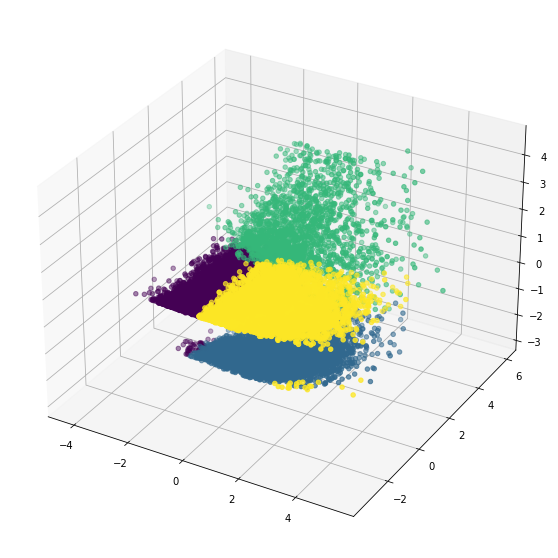

In [86]:
fig = plt.figure()
fig.set_size_inches(16, 10)

ax = plt.axes(projection='3d')
ax.scatter3D(
    data_pca_cluster['PCA_1'], 
    data_pca_cluster['PCA_2'],
    data_pca_cluster['PCA_3'], 
    c = data_pca_cluster['cluster']
);